# EDA Part II: aggregated rainfall, elevation and flooding patterns 

In this notebook, we incorporated an external dataset to look at aggregated patterns. This is done by putting Squares into administrative regions and aggregate the rainfall, elevation and flooding data.

In [ ]:
#pip install pyshp
#% pip install geopandas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import folium
from folium.plugins import HeatMap
import shapefile as shp
import seaborn as sns
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from tqdm import tqdm
from matplotlib import cm
import geopandas as gpd
import folium
from folium.plugins import HeatMap

## Reading the data
*shapes*: external dataset containing polygons of Level 3 administrative regions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read in data files
train = pd.read_csv("/content/drive/MyDrive/Final Project/Train.csv")
#sub = pd.read_csv("/content/drive/MyDrive/Final Project/SampleSubmission.csv")
shapes = gpd.read_file("/content/drive/MyDrive/Final Project/mwi_adm_nso_20181016_shp/mwi_admbnda_adm3_nso_20181016.shp")

## Data preprocessing

Generating two new datafames to study the two extreme flooding conditions

In [ ]:
# some preprocessing
train2015 = train.drop([col for col in train.columns if '2019' in col],axis=1)
precip = [i for i in range(1,18)]
train2015.columns = ['X','Y','target','elevation']+precip+['LC_Type1_mode','id']
train2015['sum'] = train2015[precip].apply(lambda x: x.sum(),axis=1)
train2015['mean'] = train2015[precip].apply(lambda x: x.mean(),axis=1)
max_flood = train2015[train2015.target==1]
no_flood = train2015[train2015.target==0]

## Matching each square to a Region

In [ ]:
# function to match Square_ID to administrative region provided in shape file 
def encodePolygon(points, polygons):
    numPoints = len(points)
    numPolygons = len(polygons)
    for idx, point in tqdm(enumerate(points)):
        row = np.zeros(numPolygons)
        for idx2, polygon in enumerate(polygons):
            if polygon.contains(point):
                row[idx2] = 1
                break
        if idx == 0:
            matrix = row
        else:
            matrix = np.vstack((matrix,row))
    return matrix.transpose()    

## Aggregate the data using some matrix operations

In [ ]:
# match Square_ID to administrative region and calculate flooding extent, total rainfall and elevation for each region
points = []
for point in zip(train2015.X.values,train2015.Y.values):
    points.append(Point(point[0],point[1]))
polygons = shapes.geometry.values
    
point_polygon_matrix = encodePolygon(points,polygons)
numPoints = point_polygon_matrix.sum(axis=1).transpose()
shapes = shapes.assign(num_points = numPoints)

# flood
target = train2015.target.values
flooded_polygons = point_polygon_matrix.dot(target.transpose())
# rainfall
rainfall = train2015['sum'].values
rainfall_polygons = point_polygon_matrix.dot(rainfall.transpose())
# elevation
elevation = train2015.elevation.values
elevation_polygons = point_polygon_matrix.dot(elevation.transpose())
elevation_polygons = elevation_polygons / numPoints

shapes = shapes.assign(flood=flooded_polygons)
shapes = shapes.assign(rainfall=rainfall_polygons)
shapes = shapes.assign(elevation=elevation_polygons)


16466it [02:41, 102.07it/s]


In [ ]:
# filter out polygons without a Square_ID 
shapes = shapes[shapes.num_points > 0]

## Flood map

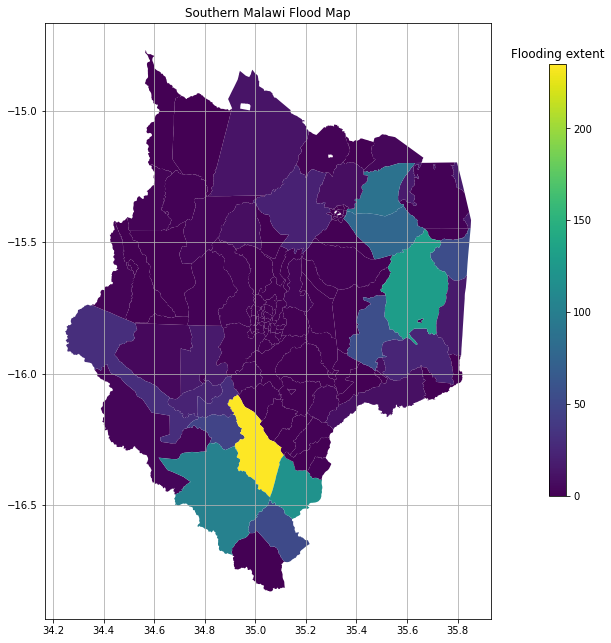

In [ ]:
# plot Malawi flood map
fig, ax = plt.subplots(1, 1,figsize=(8,12))
colormap = "viridis"
# shapes.plot(column='flood',ax=ax,legend=True,legend_kwds={'label':'Flooding extent','orientation':'vertical'})
shapes.plot(column='flood',ax=ax,cmap=colormap)

ax.set_title('Southern Malawi Flood Map')
ax.grid() 

# colorbar will be created by ...
fig = ax.get_figure()
cbax = fig.add_axes([1, 0.3, 0.03, 0.5])   
cbax.set_title('Flooding extent')
sm = plt.cm.ScalarMappable(cmap=colormap, \
                norm=plt.Normalize(vmin=min(shapes.flood), vmax=max(shapes.flood)))
sm._A = []
fig.colorbar(sm, cax=cbax, format="%d")
plt.show()

## Elevation map

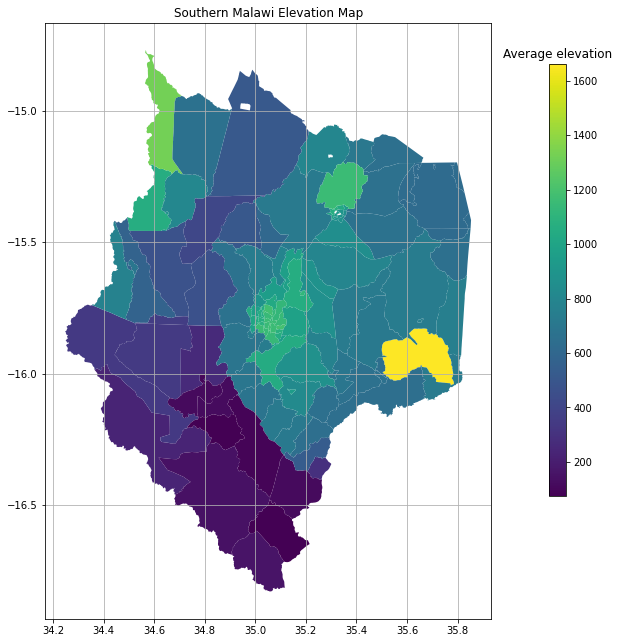

In [ ]:
# plot Malawi elevation map
fig, ax = plt.subplots(1, 1,figsize=(8,12))
colormap = "viridis"
shapes.plot(column='elevation',ax=ax,cmap=colormap)

ax.set_title('Southern Malawi Elevation Map')
ax.grid() 

# colorbar will be created by ...
fig = ax.get_figure()
cbax = fig.add_axes([1, 0.3, 0.03, 0.5])   
cbax.set_title('Average elevation')
sm = plt.cm.ScalarMappable(cmap=colormap, \
                norm=plt.Normalize(vmin=min(shapes.elevation), vmax=max(shapes.elevation)))
sm._A = []
fig.colorbar(sm, cax=cbax, format="%d")
plt.show()

## Rainfall map

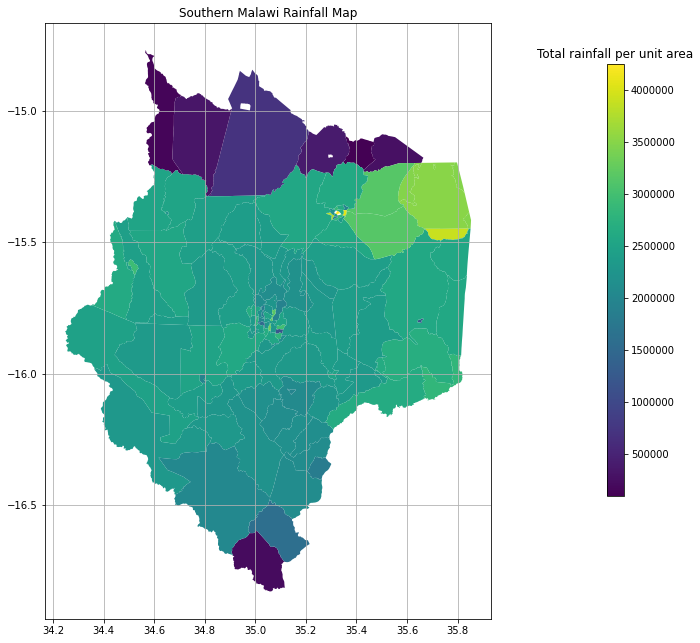

In [ ]:
# plot Malawi rainfall map
shapes['rainfall_per_unit_area'] = shapes['rainfall'] / shapes['Shape_Area']
fig, ax = plt.subplots(1, 1,figsize=(8,12))
colormap = "viridis"
shapes.plot(column='rainfall_per_unit_area',ax=ax,cmap=colormap)

ax.set_title('Southern Malawi Rainfall Map')
ax.grid() 

# colorbar will be created by ...
fig = ax.get_figure()
cbax = fig.add_axes([1.1, 0.3, 0.03, 0.5])   
cbax.set_title('Total rainfall per unit area')
sm = plt.cm.ScalarMappable(cmap=colormap, \
                norm=plt.Normalize(vmin=min(shapes.rainfall_per_unit_area), vmax=max(shapes.rainfall_per_unit_area)))
sm._A = []
fig.colorbar(sm, cax=cbax, format="%d")
plt.show()

### Observations

1. Most flooded areas are concentrated within a region
2. The worst hit flooded regions have the lowest elevation
3. Rainfall is generally well distributed across the country

## Observing geography surrounding the most flooded squares

In [41]:
# look into how the flooded regions are distributed on a geographical map
malawi_coord = [-15.683127, 35.065226]
base_map = folium.Map(location=malawi_coord, control_scale=True, zoom_start =9)
max_flood_coords = []
max_flood_lat = list(max_flood.Y.values)
max_flood_lng = list(max_flood.X.values)
for coord in zip(max_flood_lat,max_flood_lng):
    max_flood_coords.append(coord)
HeatMap(max_flood_coords,radius=8,blur=5).add_to(base_map)
base_map

### Observations

1. The worst hit regions are close to water bodies